In [1]:
import sys
sys.path.append('../Src')
import transformer_full
from libs import *

2024-06-18 22:02:57.317659: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 22:02:57.861871: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 22:02:57.861917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 22:02:57.943430: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 22:02:58.127830: I tensorflow/core/platform/cpu_feature_guar

import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3,4,5,6,7,8,9,10,11'

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

In [2]:
# Sets all random seeds for the program (Python, NumPy, and TensorFlow)
keras.utils.set_random_seed(117)
tf.config.experimental.enable_op_determinism()

# Data loading

In [3]:
wind_turbine = 'WT1'
pre_trained_model = "pre_trained_1"
project_folder = ".."
samples_per_day = 144
train_mode = True

In [4]:
years_of_data = [2020, 2021, 2022]
training_dates = pd.date_range(start='2020-06-01', end='2021-01-01', freq='min')
testing_dates = pd.date_range(start='2021-01-01', end='2022-03-01', freq='min')

In [5]:
features_list = [
    wind_turbine + "_Gear Bearing Temp. Avg.",
    wind_turbine + "_Gear Bearing Temp.B Avg.",
    wind_turbine + "_Gear Bearing Temp.C Avg.",
    wind_turbine + "_Gear Oil Temp. Avg.",
    wind_turbine + "_Gear Oil Temp.Inlet Avg.",
    wind_turbine + "_Rotor RPM Max.",
    wind_turbine + "_Rotor RPM Avg."
]

In [6]:
columns = ['gear_bearing_temp', 'gear_bearing_temp_b', 'gear_bearing_temp_c', 'gear_oil_temp', 'gear_oil_temp_inlet', 'rotor_rpm_max', 'rotor_rpm_avg']
data = pd.DataFrame(columns=columns)

In [7]:
for year in years_of_data:
    data_year = pd.read_pickle(f'{project_folder}/Data/WT{year}.pkl')

    data_year.columns = data_year.columns.str.replace(r'\(\d+\)', '').str.strip()
    data_year = data_year[features_list]
    data_year.columns = columns

    data = pd.concat([data, data_year])

/tmp/ipykernel_1160/963540068.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data_year.columns = data_year.columns.str.replace(r'\(\d+\)', '').str.strip()
/tmp/ipykernel_1160/963540068.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data_year.columns = data_year.columns.str.replace(r'\(\d+\)', '').str.strip()
/tmp/ipykernel_1160/963540068.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data_year.columns = data_year.columns.str.replace(r'\(\d+\)', '').str.strip()


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131328 entries, 2020-01-01 00:00:00 to 2022-02-28 23:50:00
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gear_bearing_temp    130812 non-null  float64
 1   gear_bearing_temp_b  130812 non-null  float64
 2   gear_bearing_temp_c  130812 non-null  float64
 3   gear_oil_temp        130812 non-null  float64
 4   gear_oil_temp_inlet  130812 non-null  float64
 5   rotor_rpm_max        130812 non-null  float64
 6   rotor_rpm_avg        130812 non-null  float64
dtypes: float64(7)
memory usage: 8.0 MB


In [9]:
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)
data.head()

,date,gear_bearing_temp,gear_bearing_temp_b,gear_bearing_temp_c,gear_oil_temp,gear_oil_temp_inlet,rotor_rpm_max,rotor_rpm_avg
0,2020-01-01 00:00:00,53.0,49.0,57.0,52.0,43.0,11.9,10.1
1,2020-01-01 00:10:00,54.0,48.0,58.0,52.0,43.0,13.7,11.6
2,2020-01-01 00:20:00,56.0,51.0,60.0,53.0,47.0,13.7,13.4
3,2020-01-01 00:30:00,57.0,51.0,60.0,53.0,44.0,13.1,12.5
4,2020-01-01 00:40:00,57.0,51.0,60.0,53.0,44.0,13.7,13.1


In [10]:
data = data.sort_values(by='date').reset_index(drop=True)

# Data pre-processing
## Averaging duplicated values

In [11]:
print(f'Number of duplicated dates: {data.shape[0] - data.date.nunique()}')

Number of duplicated dates: 17568


In [12]:
# Averaging the values for each date duplicates
data = data.groupby('date').mean().reset_index()

In [13]:
data[data.date.duplicated()]

,date,gear_bearing_temp,gear_bearing_temp_b,gear_bearing_temp_c,gear_oil_temp,gear_oil_temp_inlet,rotor_rpm_max,rotor_rpm_avg


## Filling missing values

In [14]:
data[data['gear_bearing_temp'].isna()]

,date,gear_bearing_temp,gear_bearing_temp_b,gear_bearing_temp_c,gear_oil_temp,gear_oil_temp_inlet,rotor_rpm_max,rotor_rpm_avg
18068,2020-05-05 11:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18069,2020-05-05 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18070,2020-05-05 11:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18071,2020-05-05 11:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18072,2020-05-05 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
98722,2021-11-16 13:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98723,2021-11-16 13:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98724,2021-11-16 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98725,2021-11-16 14:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
for column in data.columns:
    if column != 'date':
        data[column].interpolate(method='pchip', inplace=True)

In [16]:
data[data['gear_bearing_temp'].isna()]

,date,gear_bearing_temp,gear_bearing_temp_b,gear_bearing_temp_c,gear_oil_temp,gear_oil_temp_inlet,rotor_rpm_max,rotor_rpm_avg


## Applying moving average for smoothing the curve

In [17]:
rolling_window = samples_per_day*7

for column in data.columns:
    if column != 'date':
        data[column] = data[column].rolling(rolling_window).mean()
data = data.iloc[rolling_window - 1:].reset_index(drop=True)

## Dropping outliers

In [18]:
# Calculate z-scores for each column
data['z_scores'] = stats.zscore(data['gear_bearing_temp'], nan_policy='omit', axis=0)

# Define a threshold for outlier detection
threshold = 5

In [19]:
data.loc[data['z_scores'].abs() > threshold]

,date,gear_bearing_temp,gear_bearing_temp_b,gear_bearing_temp_c,gear_oil_temp,gear_oil_temp_inlet,rotor_rpm_max,rotor_rpm_avg,z_scores


In [20]:
outliers = data.loc[data['z_scores'].abs() > threshold].shape[0]
print(f'Number of outliers found: {outliers}')

Number of outliers found: 0


In [21]:
# Filtering out rows with z-scores greater than the threshold
data['gear_bearing_temp'] = np.where(data['z_scores'].abs() > threshold, np.nan, data['gear_bearing_temp'])
data = data.drop(columns=['z_scores'])

In [22]:
# Filling again the NaN values assigned to the outliers
data['gear_bearing_temp'].interpolate(method='pchip', inplace=True)

## Feature engineering

In [23]:
data['gear_oil_temp'] = np.mean([data['gear_oil_temp'], data['gear_oil_temp_inlet']], axis=0)
data.drop(columns=['gear_oil_temp_inlet', 'rotor_rpm_max'], inplace=True)

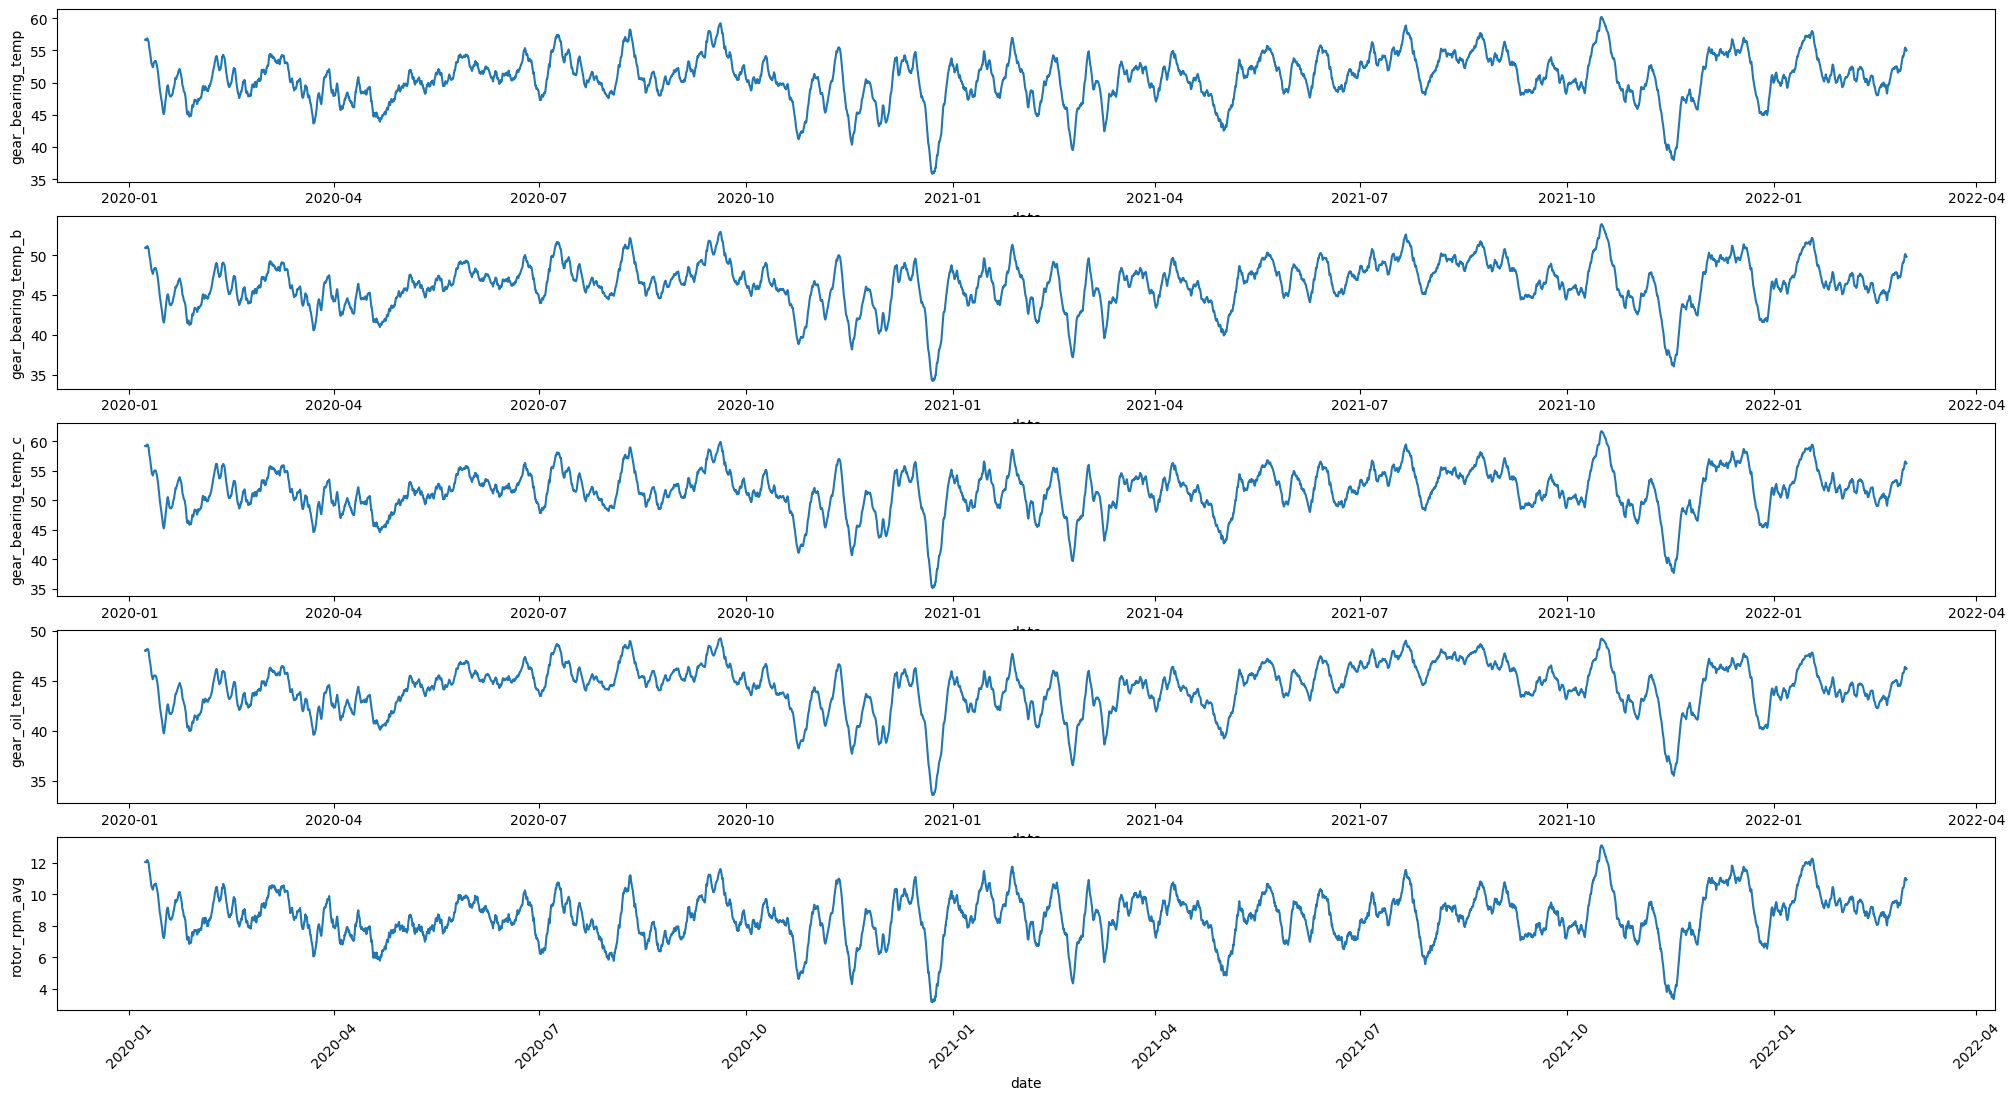

In [24]:
fig, ax = plt.subplots(5, 1, figsize =(25,13))
sns.lineplot(data=data, x='date', y='gear_bearing_temp', ax=ax[0])
sns.lineplot(data=data, x='date', y='gear_bearing_temp_b', ax=ax[1])
sns.lineplot(data=data, x='date', y='gear_bearing_temp_c', ax=ax[2])
sns.lineplot(data=data, x='date', y='gear_oil_temp', ax=ax[3])
#sns.lineplot(data=data, x='date', y='gear_oil_temp_inlet', ax=ax[4])
#sns.lineplot(data=data, x='date', y='rotor_rpm_max', ax=ax[5])
sns.lineplot(data=data, x='date', y='rotor_rpm_avg', ax=ax[4])
_=plt.xticks(rotation=45)

## Reducing frequency

data.index = pd.to_datetime(data['date'])
data = pd.Series(data['gear_bearing_temp'])
data

data = data.resample(rule='H').mean()
data

data = pd.DataFrame(data).reset_index()

## Differencing by year to obtain stationarity

data['gear_bearing_temp'] = data['gear_bearing_temp'].diff(samples_per_day * 365)
data.dropna(inplace=True)

fig, ax = plt.subplots(figsize =(16,8))
sns.lineplot(data=data, x='date', y='gear_bearing_temp', ax=ax)
_=plt.xticks(rotation=45)

## Train-test Split

In [25]:
# Selecting training and testing data
training_set = data[data['date'].isin(training_dates)]
testing_set = data[data['date'].isin(testing_dates)]

In [26]:
scaler = MinMaxScaler()
scaler.fit(training_set.iloc[:,1:])

training_set.iloc[:,1:]=scaler.transform(training_set.iloc[:,1:])
testing_set.iloc[:,1:]=scaler.transform(testing_set.iloc[:,1:])

/tmp/ipykernel_1160/4121710166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set.iloc[:,1:]=scaler.transform(training_set.iloc[:,1:])
/tmp/ipykernel_1160/4121710166.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_set.iloc[:,1:]=scaler.transform(testing_set.iloc[:,1:])


In [27]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        #end_ix = n_steps*i + n_steps
        end_ix = i + n_steps
        #start_ix = end_ix - n_steps
        # check if we are beyond the dataset
        if end_ix >= len(sequences):
            break
            # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, 1:], sequences.iloc[end_ix, 1]
        #seq_x = list(sequences.iloc[i:end_ix, 1:].mean())
        #seq_y = sequences.iloc[end_ix, 1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
n_steps = samples_per_day
x_train, y_train = split_sequences(training_set, n_steps)
print(x_train.shape, y_train.shape)

(30673, 144, 5) (30673,)


In [29]:
x_test, y_test = split_sequences(testing_set, n_steps)
print(x_test.shape, y_test.shape)

(60912, 144, 5) (60912,)


# Model definition and training

In [30]:
import sys
sys.path.append(f'{project_folder}/Notebooks')
import transformer_full

In [31]:
def get_compiled_model(x_train, y_train):
    input_shape = x_train.shape[1:]

    model = transformer_full.build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[100],
    mlp_dropout=0.3,
    dropout=0.2,
)

    model.compile(loss="mean_squared_error",
        optimizer = keras.optimizers.Adam(learning_rate=0.0003)
    )

    return model

# Enumerate and print all layers in the model
for i, layer in enumerate(model.layers):
    print(i, layer.name)

In [32]:
# load the model and prepare for continuing training
model = keras.models.load_model(f'{project_folder}/Models/{pre_trained_model}.h5')

# freeze all layers except the last dense layers
"""for layer in model.layers[:23]:
    layer.trainable = False"""
    
model.compile(loss="mean_squared_error",
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
)

callbacks = [keras.callbacks.ModelCheckpoint(f"{project_folder}/Models/FT_{wind_turbine}_v1.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    #validation_data=(x_val, y_val),
    shuffle=False,
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
)

2024-06-18 22:03:21.410754: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 22:03:21.727121: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 22:03:21.727175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 22:03:21.729088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-18 22:03:21.729177: I external/local_xla/xla/stream_executor

Epoch 1/30


2024-06-18 22:03:29.047276: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 22:03:30.361830: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-18 22:03:31.314329: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-18 22:03:31.506690: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc74d75d4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-18 22:03:31.506731: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-18 22:03:31.526375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718766211.624905    1259 device_compiler.

384/384 [==============================] - 52s 106ms/step - loss: 3.8734e-04 - val_loss: 5.6266e-04
Epoch 2/30


/home/juasesan/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


384/384 [==============================] - 40s 103ms/step - loss: 3.5454e-04 - val_loss: 5.8618e-04
Epoch 3/30
384/384 [==============================] - 40s 104ms/step - loss: 3.3919e-04 - val_loss: 6.0632e-04
Epoch 4/30
384/384 [==============================] - 39s 102ms/step - loss: 3.4586e-04 - val_loss: 5.6616e-04
Epoch 5/30
384/384 [==============================] - 39s 101ms/step - loss: 3.4774e-04 - val_loss: 5.2838e-04
Epoch 6/30
384/384 [==============================] - 40s 103ms/step - loss: 3.4105e-04 - val_loss: 5.0293e-04
Epoch 7/30
384/384 [==============================] - 40s 103ms/step - loss: 3.3040e-04 - val_loss: 4.6259e-04
Epoch 8/30
384/384 [==============================] - 40s 104ms/step - loss: 3.4107e-04 - val_loss: 4.2899e-04
Epoch 9/30
384/384 [==============================] - 40s 103ms/step - loss: 3.2939e-04 - val_loss: 3.9489e-04
Epoch 10/30
384/384 [==============================] - 40s 105ms/step - loss: 3.3319e-04 - val_loss: 3.5793e-04
Epoch 11/30

In [33]:
model.save(f'{project_folder}/Models/FT_{wind_turbine}_v1.h5')
history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{project_folder}/Training_history/FT_{wind_turbine}_history.csv', index=False)

loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

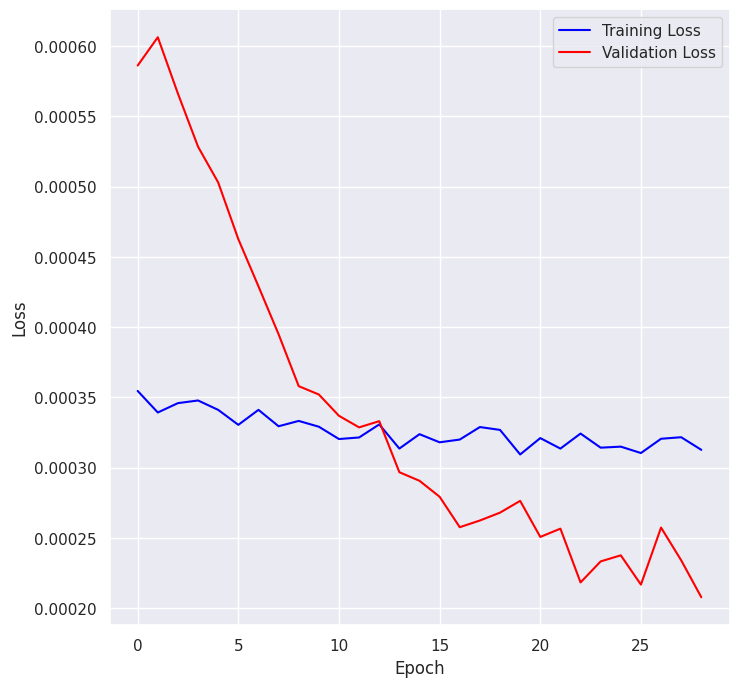

In [34]:
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(8,8))
sns.lineplot(data=loss, ax = ax, color="b", label='Training Loss')
sns.lineplot(data=val_loss, ax = ax, color="r", label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

# save plot as image
plt.savefig(f'{project_folder}/Training_plots/pre_training/FT_{wind_turbine}_loss.png')

# Model evaluation

In [35]:
y_train_pred = model.predict(x_train)

959/959 [==============================] - 20s 20ms/step


In [36]:
y_pred = model.predict(x_test)

1904/1904 [==============================] - 38s 20ms/step


In [37]:
y_train = y_train.reshape(-1)
y_train_pred = y_train_pred.reshape(-1)

In [38]:
# There is a shift of n_steps between the predictions and the true values
n_steps = 2

In [39]:
training_dates = data[data['date'].isin(training_dates)].date
testing_dates = data[data['date'].isin(testing_dates)].date

In [40]:
train_results = pd.DataFrame({'date':training_dates[samples_per_day + n_steps:],
                              'Real':y_train[:-1*n_steps],
                              'Predicted': y_train_pred[n_steps:]})
train_results

,date,Real,Predicted
21027,2020-06-02 00:20:00,0.718600,0.727276
21028,2020-06-02 00:30:00,0.718940,0.727632
21029,2020-06-02 00:40:00,0.719194,0.727979
21030,2020-06-02 00:50:00,0.719364,0.728305
21031,2020-06-02 01:00:00,0.719491,0.728607
...,...,...,...
51693,2020-12-31 23:20:00,0.718261,0.729278
51694,2020-12-31 23:30:00,0.718388,0.729017
51695,2020-12-31 23:40:00,0.718643,0.728838
51696,2020-12-31 23:50:00,0.718940,0.728800


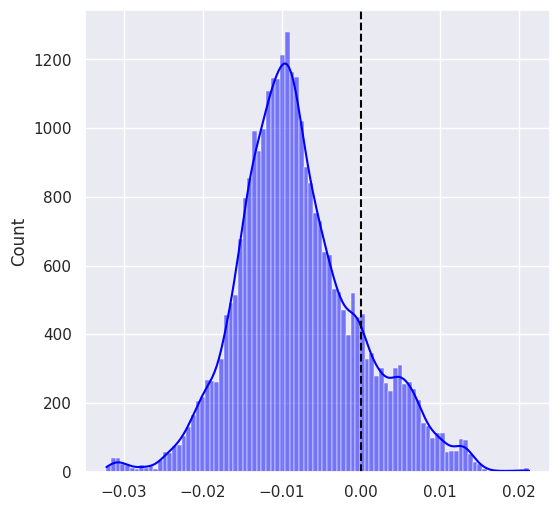

In [41]:
# Checking for bias in the residuals distribution plot
residuals = train_results['Real'] - train_results['Predicted']

sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

Biased mean:  -0.007892366201837309


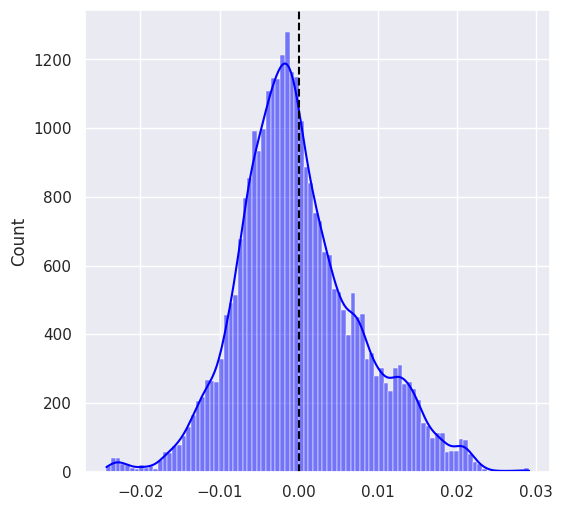

In [42]:
biased_mean = np.mean(train_results['Real'] - train_results['Predicted'])
print("Biased mean: ", biased_mean)

train_results['Predicted'] += biased_mean

# Plotting the distribution of the residuals again
residuals = train_results['Real'] - train_results['Predicted']

sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(6,6))
sns.histplot(residuals, kde=True, color='blue', ax=ax)
plt.axvline(x=0, color='black', linestyle='--')

In [43]:
train_results['Residual'] = abs(train_results.Real - train_results.Predicted)

In [44]:
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=train_results, x='date', y='Real', ax = ax, color="b", label='Real')
sns.lineplot(data=train_results, x='date', y='Predicted', ax = ax, color="r", label='Predicted')

<Axes: xlabel='date', ylabel='Real'>

In [45]:
window = samples_per_day * 7   #Averaged per week
#averaged_error = train_results.Residual.rolling(window = window).mean()[window-1:]
averaged_error = train_results.Residual.ewm(span=window).mean()

In [46]:
mean = np.mean(averaged_error)
std = np.std(averaged_error)

In [47]:
threshold_k3 = mean+3.*std
threshold_k6 = mean+6.*std
threshold_k7 = mean+7.*std

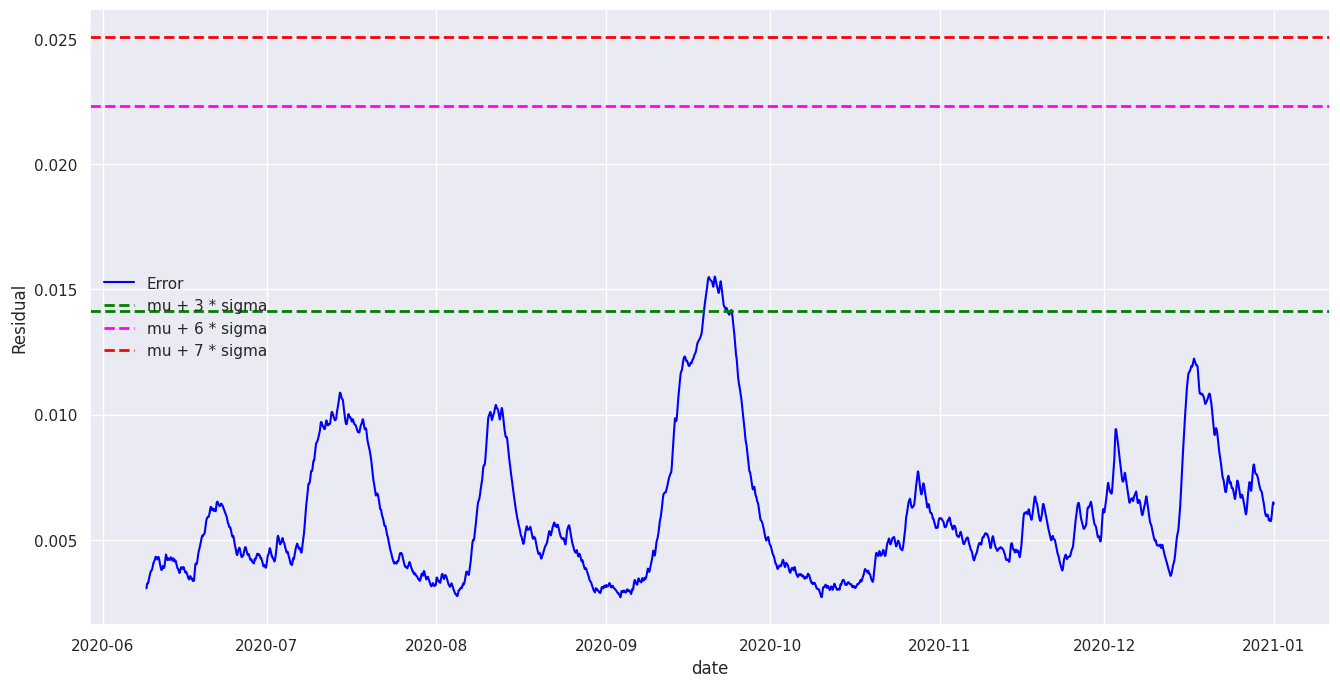

In [48]:
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=train_results.date[window-1:], y=averaged_error, ax = ax, color="b", label='Error')

plt.axhline(y = threshold_k3, color = 'green', linestyle = '--', linewidth=2, label='mu + 3 * sigma')
plt.axhline(y = threshold_k6, color = 'fuchsia', linestyle = '--', linewidth=2, label='mu + 6 * sigma')
plt.axhline(y = threshold_k7, color = 'red', linestyle = '--', linewidth=2, label='mu + 7 * sigma')

plt.legend(frameon=False)

## Test set

In [49]:
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

In [50]:
test_result = pd.DataFrame({'date':testing_dates[samples_per_day + n_steps:],
                          'Real':y_test[:-1*n_steps],
                          'Predicted': y_pred[n_steps:]})
test_result

,date,Real,Predicted
51843,2021-01-02 00:20:00,0.682121,0.691987
51844,2021-01-02 00:30:00,0.682460,0.692416
51845,2021-01-02 00:40:00,0.682842,0.692828
51846,2021-01-02 00:50:00,0.683139,0.693239
51847,2021-01-02 01:00:00,0.683266,0.693630
...,...,...,...
112748,2022-02-28 23:10:00,0.820276,0.837908
112749,2022-02-28 23:20:00,0.820191,0.837727
112750,2022-02-28 23:30:00,0.820064,0.837552
112751,2022-02-28 23:40:00,0.819894,0.837369


In [51]:
score = np.sqrt(metrics.mean_squared_error(test_result.Real,test_result.Predicted))
print("Score RMSE: {}".format(score))

Score RMSE: 0.013943603871057593


In [52]:
test_result['Predicted'] += biased_mean

In [53]:
test_result['Residual'] = abs(test_result['Real'] - test_result['Predicted'])

<Axes: xlabel='date', ylabel='Real'>

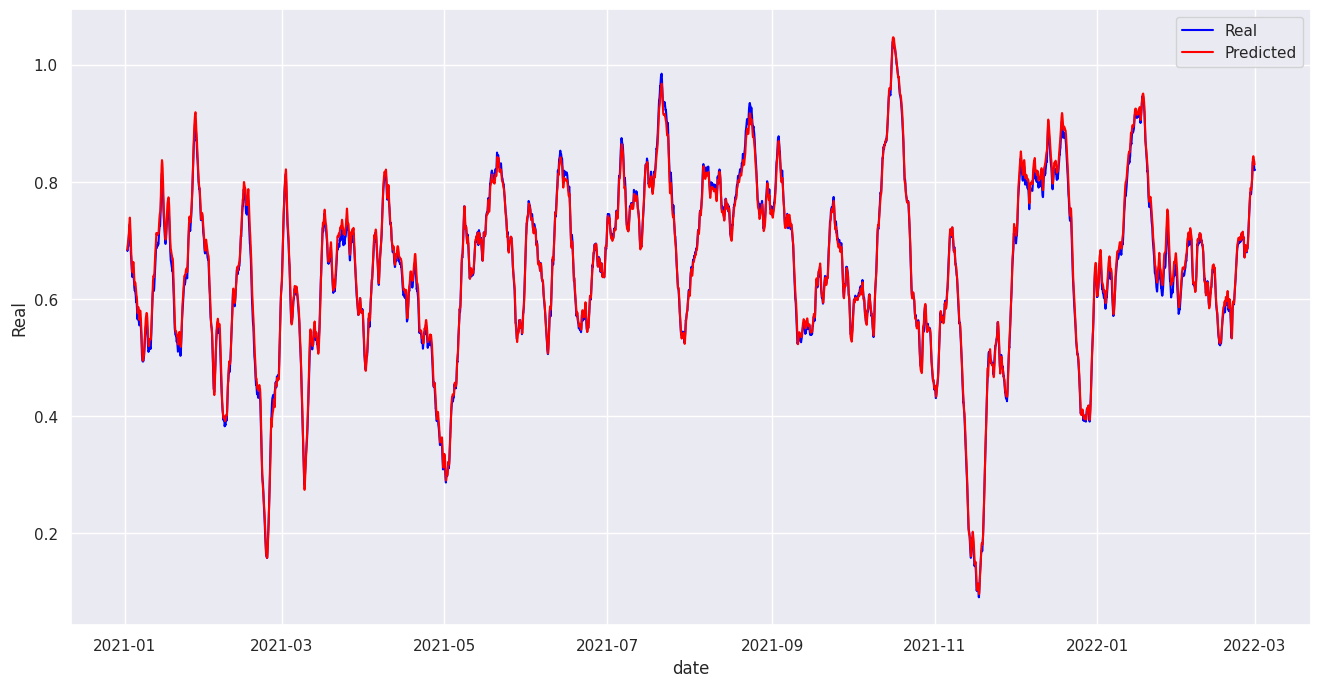

In [54]:
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=test_result, x='date', y='Real', ax = ax, color="b", label='Real')
sns.lineplot(data=test_result, x='date', y='Predicted', ax = ax, color="r", label='Predicted')

In [55]:
window = samples_per_day * 7  #Averaged per week
#averaged_error = test_result.Residual.rolling(window = window).mean()[window-1:]
averaged_error = test_result.Residual.ewm(span=window).mean()

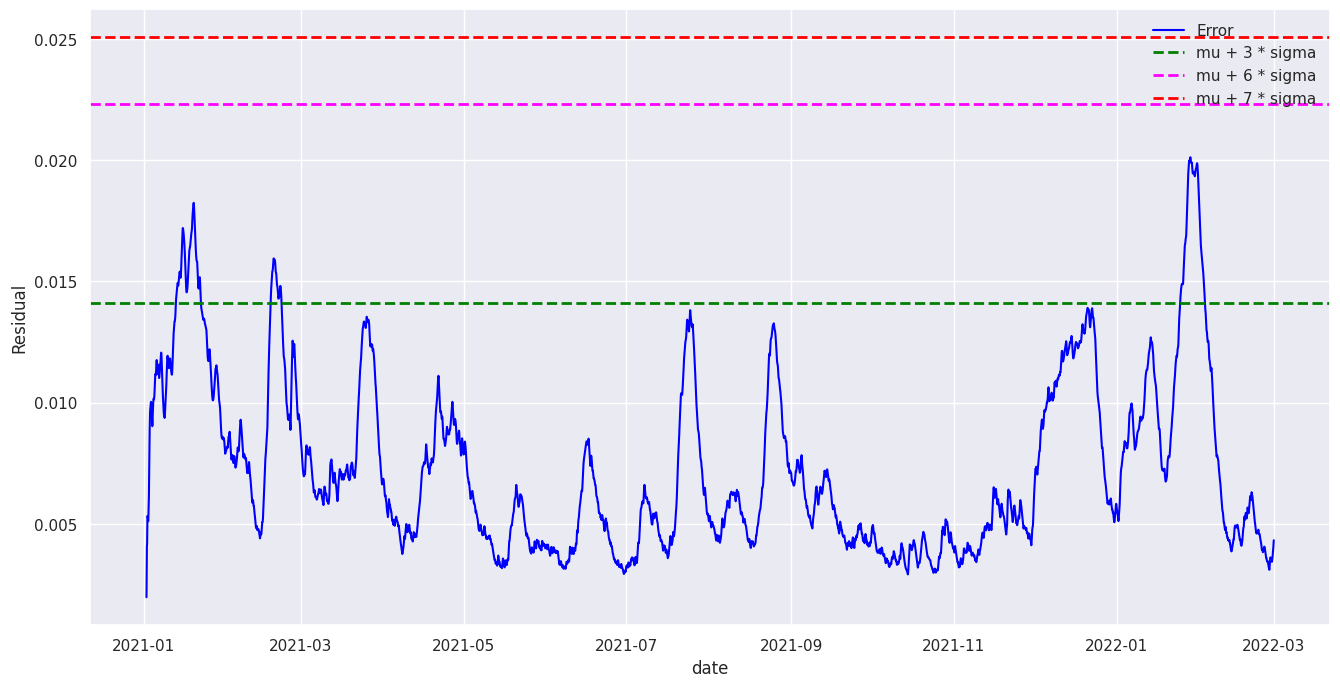

In [56]:
sns.set_theme(palette="ch:s=.25,rot=-.25")
fig,ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=test_result.date, y=averaged_error, ax = ax, color="b", label='Error')

plt.axhline(y = threshold_k3, color = 'green', linestyle = '--', linewidth=2, label='mu + 3 * sigma')
plt.axhline(y = threshold_k6, color = 'fuchsia', linestyle = '--', linewidth=2, label='mu + 6 * sigma')
plt.axhline(y = threshold_k7, color = 'red', linestyle = '--', linewidth=2, label='mu + 7 * sigma')

plt.legend(frameon=False)

In [57]:
window_size = samples_per_day * 7 
exceedances = averaged_error.rolling(window=window_size).apply(lambda x: all(x > threshold_k6), raw=True)
test_result['Alarm'] = exceedances

In [58]:
test_result.loc[test_result['Alarm'] == 1.0]

,date,Real,Predicted,Residual,Alarm


In [59]:
if test_result.loc[test_result['Alarm'] == 1.0].shape[0] == 0:
    print("No alarm was triggered")
else:
    alarm_date = str(test_result.loc[test_result['Alarm'] == 1.0]['date'].iloc[0])
    print(f'Alarm triggered at {alarm_date}')

No alarm was triggered
